# Code Final


## import some packages


In [ ]:
!pip install ucimlrepo

In [ ]:
import time
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from sklearn.metrics import classification_report


# For data preprocess
from ucimlrepo import fetch_ucirepo
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from plotnine import *

myseed = 42  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## Some exploratory analysis

In [ ]:
# fetch dataset
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890)

# data (as pandas dataframes)
X = aids_clinical_trials_group_study_175.data.features
y = aids_clinical_trials_group_study_175.data.targets

# metadata
print('metadata:\n', aids_clinical_trials_group_study_175.metadata)

# variable information
print('variables:\n', aids_clinical_trials_group_study_175.variables)

X = X.drop('zprior', axis=1)

metadata:
 {'uci_id': 890, 'name': 'AIDS Clinical Trials Group Study 175', 'repository_url': 'https://archive.ics.uci.edu/dataset/890/aids+clinical+trials+group+study+175', 'data_url': 'https://archive.ics.uci.edu/static/public/890/data.csv', 'abstract': 'The AIDS Clinical Trials Group Study 175 Dataset contains healthcare statistics and categorical information about patients who have been diagnosed with AIDS. This dataset was initially published in 1996. The prediction task is to predict whether or not each patient died within a certain window of time or not. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 2139, 'num_features': 23, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Sexual Orientation', 'Race', 'Gender'], 'target_col': ['cid'], 'index_col': ['pidnum'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1996, 'last_updated'

In [ ]:
# 样本正负比例
print(y[y.cid == 1].shape)
print(y[y.cid == 0].shape)

(521, 1)
(1618, 1)


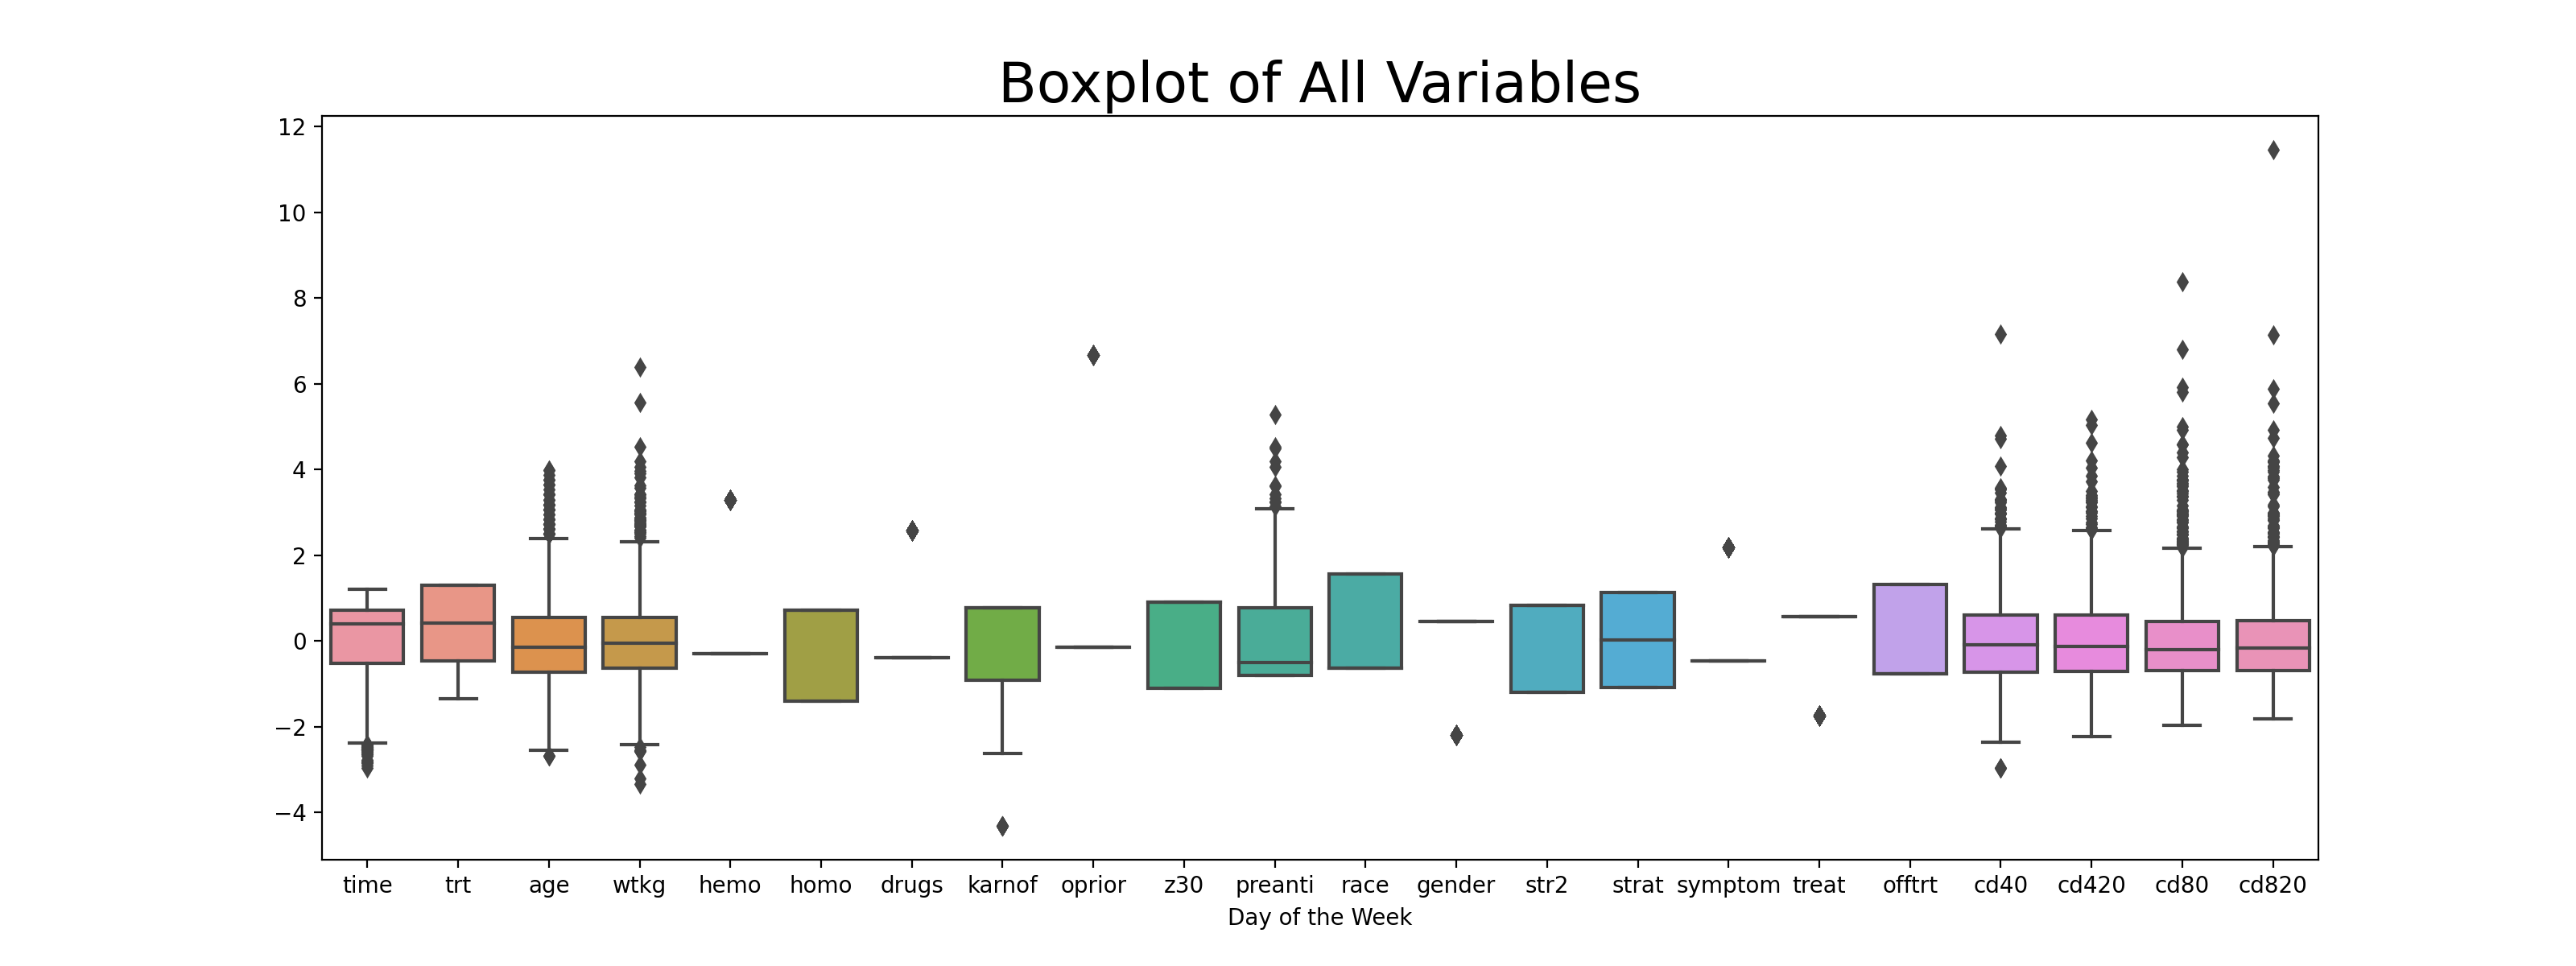

In [ ]:
# 画箱线图
plt.figure(figsize=(16, 6))
X1 = (X - X.mean()) / X.std()
sns.boxplot(data=X1)
plt.title('Boxplot of All Variables', size=25)
plt.xlabel("Day of the Week")
plt.show()

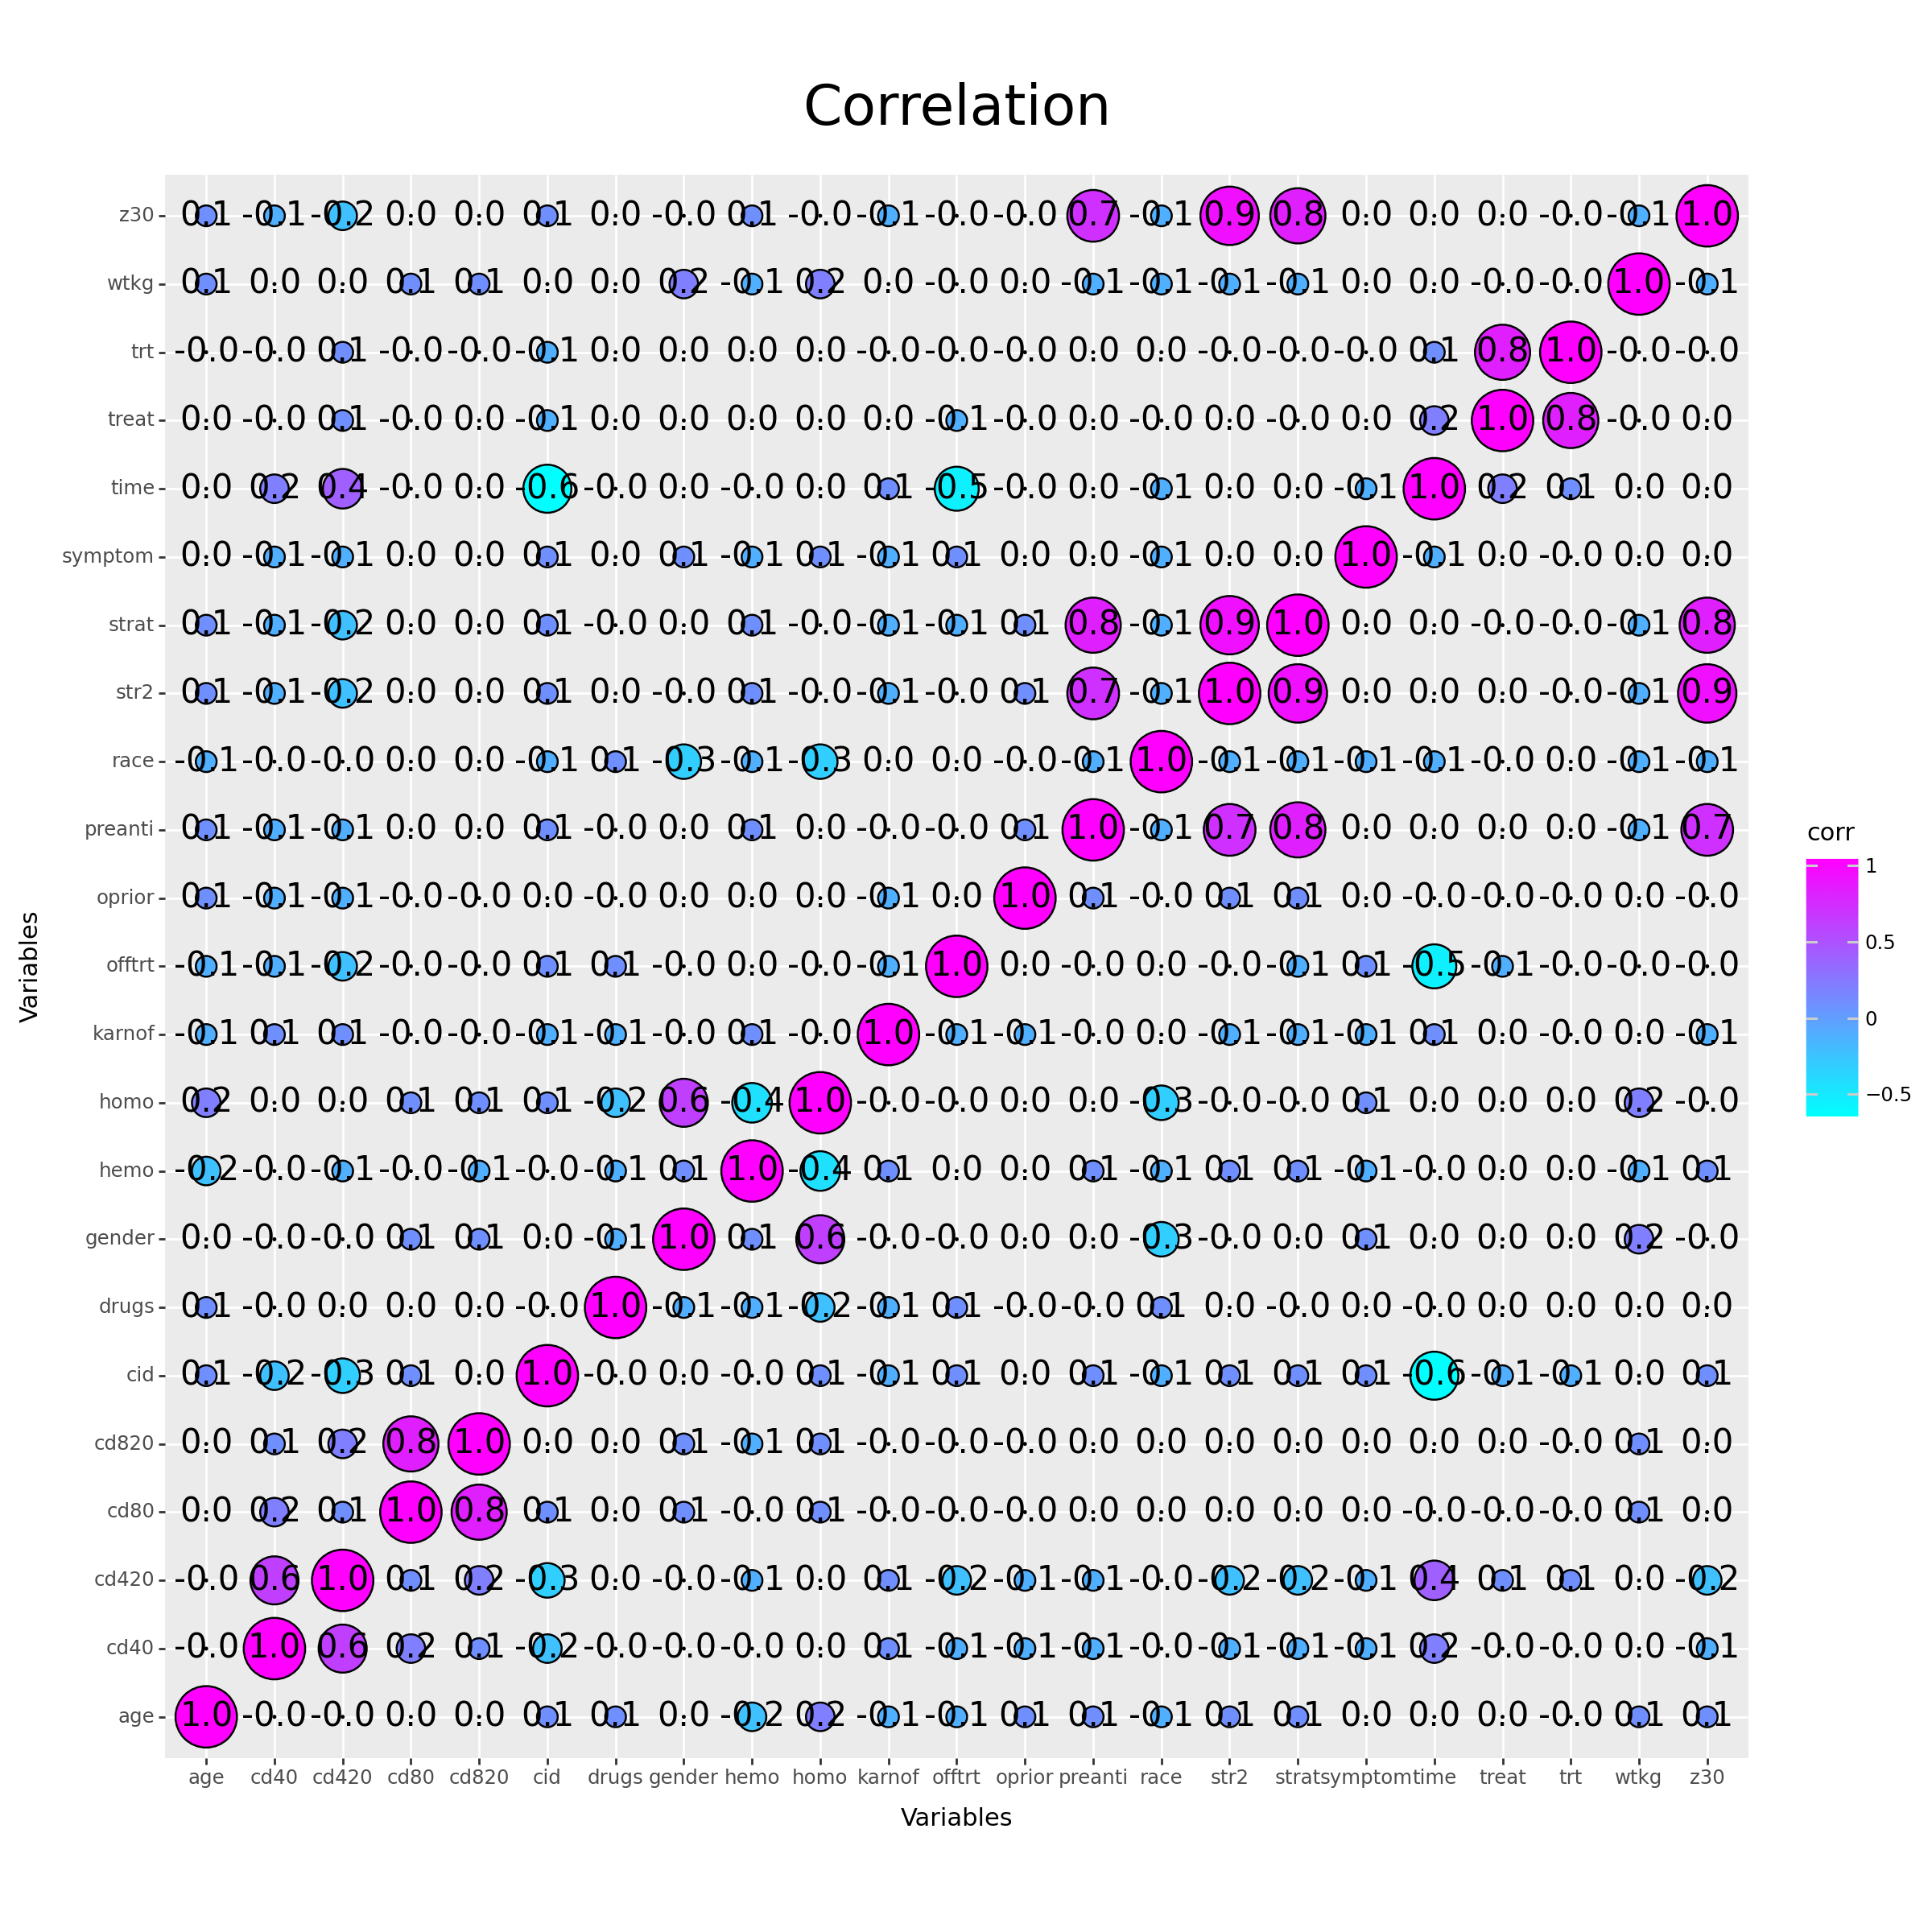

<Figure Size: (1200 x 1200)>

In [ ]:
# plot corr image

X1['cid'] = y
mat_corr = np.round(X1.corr(),1).reset_index()
mydata=pd.melt(mat_corr,id_vars='index',var_name='var',value_name='value')
mydata['AbsValue']=np.abs(mydata.value)
(
    ggplot(mydata, aes(x ='index', y ='var', fill = 'value',size='AbsValue')) +
    geom_point(shape='o',color="black") +
    scale_size_area(max_size=15, guide=False) +
    scale_fill_cmap(name ='corr', cmap_name = 'cool')+
    coord_equal()+
    geom_text(aes(label='value'), size=15,colour="black")+
    theme(dpi=100,figure_size=(12,12), plot_title=element_text(hjust=0.5, size = 25))+
    ggtitle("Correlation")+
    xlab("Variables")+
    ylab("Variables")
)

In [ ]:
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

print(calculate_vif(X))
calculate_vif(X).to_excel('vif1.xlsx')
X['const'] = 1.0
print(calculate_vif(X))
calculate_vif(X).to_excel('vif2.xlsx')
X['cid'] = y
print(X.corr(method='pearson')['cid'])
X.corr(method='pearson')['cid'].to_excel('corr_y.xlsx')
X = X.drop('cid', axis=1)
print(X.corr()[X.corr() > 0.7][X.corr() != 1.0].stack().reset_index().drop_duplicates(0))

   Features  VIF Factor
0      time   14.523867
1       trt    7.184702
2       age   18.376220
3      wtkg   35.207679
4      hemo    1.945521
5      homo    8.140658
6     drugs    1.289097
7    karnof   73.849893
8    oprior    1.227051
9       z30   14.311612
10  preanti    6.329842
11     race    1.673209
12   gender   12.936134
13     str2   28.065910
14    strat   75.659940
15  symptom    1.275977
16    treat   10.654109
17   offtrt    1.999746
18     cd40   18.689224
19    cd420   17.172746
20     cd80   15.798515
21    cd820   16.379187
   Features  VIF Factor
0      time    1.464274
1       trt    2.551080
2       age    1.134646
3      wtkg    1.112608
4      hemo    1.785600
5      homo    2.764803
6     drugs    1.123532
7    karnof    1.061282
8    oprior    1.200245
9       z30    6.437224
10  preanti    3.930038
11     race    1.203816
12   gender    2.227238
13     str2   11.678592
14    strat   13.344077
15  symptom    1.066653
16    treat    2.652089
17   offtrt    1

In [ ]:
X = X.drop('treat', axis=1)
X = X.drop('z30', axis=1)
X = X.drop('preanti', axis=1)
X = X.drop('str2', axis=1)
X = X.drop('cd80', axis=1)
strat_dummy = pd.get_dummies(X['strat'], prefix='strat')
trt_dummy = pd.get_dummies(X['trt'], prefix='trt')
X = X.join(strat_dummy.iloc[:,:2])
X = X.join(trt_dummy.iloc[:,:3])
X = X.drop('strat', axis=1)
X = X.drop('trt', axis=1)
print(calculate_vif(X))

   Features  VIF Factor
0      time    1.461108
1       age    1.129144
2      wtkg    1.109960
3      hemo    1.783681
4      homo    2.754908
5     drugs    1.122739
6    karnof    1.062007
7    oprior    1.035390
8      race    1.202128
9    gender    2.226169
10  symptom    1.063134
11   offtrt    1.334731
12     cd40    1.568018
13    cd420    1.924780
14    cd820    1.093862
15    const  355.106998
16  strat_1    1.367406
17  strat_2    1.245074
18    trt_0    1.510123
19    trt_1    1.476399
20    trt_2    1.472925


In [ ]:
try:
    X2 = X.drop('const', axis=1)
except KeyError as e:
    print(e)
    X2 = X
def stepwise_selection(X, y,
                       initial_list=[],
                       verbose=True,
                       itr=500):
    included = list(initial_list)
    count = 0
    aic_list = []
    num = [0]
    while True:
        if count >= itr:
            break
        changed = False
        # 前向选择
        count += 1
        excluded = list(set(X.columns) - set(included))
        new_aic = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(X[included + [new_column]])).fit()
            new_aic[new_column] = model.aic
        if new_aic.isnull().all():  # 处理new_aic为空的情况
            break
        best_feature = new_aic.idxmin()
        best_aic = new_aic.min()
        included.append(best_feature)
        changed = True
        if verbose:
            print('Add  {:30} with AIC {:.7}'.format(best_feature, best_aic))
            aic_list.append(best_aic)
            num.append(num[-1] + 1)

        # 后向剔除
        model = sm.Logit(y, sm.add_constant(X[included])).fit()
        aic = model.aic
        worst_feature = None
        for column in included:
            temp_included = list(set(included) - {column})
            temp_model = sm.Logit(y, sm.add_constant(X[temp_included])).fit()
            if temp_model.aic < aic:
                aic = temp_model.aic
                worst_feature = column
        if worst_feature is not None:
            included.remove(worst_feature)
            changed = True
            if verbose:
                print('Drop {:30} with AIC {:.7}'.format(worst_feature, aic))
                aic_list.append(aic)
                num.append(num[-1] - 1)
        if not changed:
            break
        if worst_feature == best_feature:
            break
    return included
selected = stepwise_selection(X2, y)

Optimization terminated successfully.
         Current function value: 0.547377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.554382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553665
         Iterations 5
Optimization terminated successfully.

<ipython-input-156-531a20e0fb3d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



         Current function value: 0.555125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.554109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483327
         Iterations 6
Optimization term

<ipython-input-156-531a20e0fb3d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Optimization terminated successfully.
         Current function value: 0.393356
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377678
  

<ipython-input-156-531a20e0fb3d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Optimization terminated successfully.
         Current function value: 0.365264
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364906
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368540
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366651
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364564
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367765
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360096
  

<ipython-input-156-531a20e0fb3d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Optimization terminated successfully.
         Current function value: 0.346831
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345811
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347715
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347747
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344044
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347576
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347872
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344591
  

<ipython-input-156-531a20e0fb3d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Optimization terminated successfully.
         Current function value: 0.341928
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340733
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340465
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342042
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340484
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342049
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341870
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339536
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342241
  

<ipython-input-156-531a20e0fb3d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Optimization terminated successfully.
         Current function value: 0.338601
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337548
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336632
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337126
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338494
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338004
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338840
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338860
  

<ipython-input-156-531a20e0fb3d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Optimization terminated successfully.
         Current function value: 0.334403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336441
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336098
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336376
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335481
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336453
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335563
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336359
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336308
  

<ipython-input-156-531a20e0fb3d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Optimization terminated successfully.
         Current function value: 0.333213
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334379
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333374
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334372
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333307
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333408
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334119
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334403
         Iterations 7
Add  symptom                        with AIC 1441.945
Optimization terminated succ

<ipython-input-156-531a20e0fb3d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Optimization terminated successfully.
         Current function value: 0.332401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332830
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332005
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331911
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332853
         Iterations 7
Add  drugs                          with AIC 1439.265
Optimization terminated successfully.
         Current function value: 0.331759
         Iterations 7
Optimization terminated succ

<ipython-input-156-531a20e0fb3d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Optimization terminated successfully.
         Current function value: 0.331264
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331748
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331214
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330868
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331617
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331759
         Iterations 7
Add  karnof                         with AIC 1436.23
Optimization terminated successfully.
         Current function value: 0.330582
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468721
         Iterations 6
Optimization terminated succe

<ipython-input-156-531a20e0fb3d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Optimization terminated successfully.
         Current function value: 0.329752
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330454
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330046
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330577
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330533
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330087
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330443
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330582
         Iterations 7
Add  strat_2                        with AIC 1433.813
Optimization terminated succ

<ipython-input-156-531a20e0fb3d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Optimization terminated successfully.
         Current function value: 0.329549
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329028
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329435
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329547
         Iterations 7
Add  hemo                           with AIC 1431.485
Optimization terminated successfully.
         Current function value: 0.328538
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355561
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344340
         Iterations 7
Optimization terminated succ

<ipython-input-156-531a20e0fb3d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Optimization terminated successfully.
         Current function value: 0.328531
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.328485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.328441
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.328308
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.328533
         Iterations 7
Add  cd40                           with AIC 1431.13
Optimization terminated successfully.
         Current function value: 0.327987
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354776
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341582
         Iterations 7
Optimization terminated succe

<ipython-input-156-531a20e0fb3d>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



         Current function value: 0.327957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.327889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.327748
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.327983
         Iterations 7
Add  gender                         with AIC 1432.104
Optimization terminated successfully.
         Current function value: 0.327748
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354523
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341185
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330522
         Iterations 7
Optimization terminated successfully.
         Current function v

In [ ]:
selected

['time',
 'offtrt',
 'cd420',
 'race',
 'cd820',
 'age',
 'strat_1',
 'symptom',
 'drugs',
 'karnof',
 'strat_2',
 'hemo',
 'cd40']

In [ ]:
data = X.copy()
data['cid'] = y['cid']
data

,time,age,wtkg,hemo,homo,drugs,karnof,oprior,race,gender,...,cd40,cd420,cd820,const,strat_1,strat_2,trt_0,trt_1,trt_2,cid
0,948,48,89.8128,0,0,0,100,0,0,0,...,422,477,324,1.0,1,0,0,0,1,0
1,1002,61,49.4424,0,0,0,90,0,0,0,...,162,218,564,1.0,0,0,0,0,0,1
2,961,45,88.4520,0,1,1,90,0,0,1,...,326,274,1893,1.0,0,0,0,0,0,0
3,1166,47,85.2768,0,1,0,100,0,0,1,...,287,394,966,1.0,0,0,0,0,0,0
4,1090,43,66.6792,0,1,0,100,0,0,1,...,504,353,782,1.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,1091,21,53.2980,1,0,0,100,0,0,1,...,152,109,720,1.0,0,0,0,0,0,0
2135,395,17,102.9672,1,0,0,100,0,1,1,...,373,218,1030,1.0,0,0,1,0,0,0
2136,1104,53,69.8544,1,1,0,90,0,1,1,...,419,364,1041,1.0,0,0,0,0,1,0
2137,465,14,60.0000,1,0,0,100,0,0,1,...,166,169,1838,1.0,1,0,1,0,0,1


## Preprocess
Prepare train data and test data here

### Dataset
Do normalization, extract features and split dataset here


In [ ]:
class AidsDataset(Dataset):
    ''' Dataset for loading and preprocessing the Aids dataset '''
    def __init__(self,
                 mode,
                 data: pd.DataFrame,
                 selected=None):
        '''
        selected means selected features
        mode: train or test
        '''


        # Normalization
        continues = []
        for i in data.columns:
            if max(data[i]) > 1:
                continues.append(i)
        data[continues] = (data[continues] - data[continues].mean()) / data[continues].std()

        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data['cid'], test_size=0.25, random_state=42)

        # if selected features
        if not selected:
            feats = data.iloc[:,:-1].columns
        else:
            feats = selected

        print(feats)
        # Splitting training data into train & test sets
        if mode == 'train':
            data = X_train[feats]
            target = y_train
        elif mode == 'test':
            data = X_test[feats]
            target = y_test


        # Convert data into PyTorch tensors
        self.data = torch.FloatTensor(data.values)
        self.target = torch.FloatTensor(target.values)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of Aids Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))



    def get_data(self):
        return self.data, self.target

    def __getitem__(self, index):
        # Returns one sample at a time
        return self.data[index], self.target[index]


    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

### DataLoader

A `DataLoader` loads data from a given `Dataset` into batches.


In [ ]:
def prep_dataloader(mode, data, batch_size, n_jobs=0, selected=None):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = AidsDataset(mode=mode, data=data, selected=selected)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

## Deep Neural Network

Design network structure here.

This module also included a function `cal_loss` for calculating loss.


In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here

        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

        # Choose loss function, like mean squared error loss
        self.criterion = nn.BCELoss()

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        loss = self.criterion(pred, target)
        #return loss
        #此处正则化
        #L1
        '''l1Loss = 0
        for i in self.parameters():
            l1Loss += torch.sum(abs(i))
        return 0.001*l1Loss+loss, loss'''
        #L2
        l2Loss = 0
        for i in self.parameters():
            l2Loss += torch.sum(torch.pow(i,2))
        return 0.0001*l2Loss+loss, loss

## Train and test

### Training

In [ ]:
def train(tr_set, tt_set, model, config, device):
    ''' NN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'test': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss, train_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(train_loss.detach().cpu().item())

        # After each epoch, test your model on the test set.
        test_mse = test(tt_set, model, device)
        if test_mse < min_mse:
            # Save model if your model improved
            min_mse = test_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['test'].append(test_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if  model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## Test

In [ ]:
def test(test_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in test_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss, loss = model.cal_loss(pred, y)  # compute loss
        total_loss += loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(test_set.dataset)              # compute averaged loss

    return total_loss

##  Setup Hyper-parameters

`config` contains hyper-parameters for training and the path to save your model.

In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/

# To tune these hyper-parameters to improve model's performance
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 300,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 500,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

### Plot training process

In [ ]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of model (train & test loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['test'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['test'], c='tab:cyan', label='test')
    plt.ylim(0.0, 1.)
    plt.xlabel('Training steps')
    plt.ylabel('BCELoss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()
    figure(figsize=(5, 5))
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.bar(range(len(preds)), preds, width=0.4, align='center', label='Predictions', color='blue')
    plt.bar([x+0.4 for x in range(len(targets))], targets, width=0.4, align='center', label='Ground Truth', color='red')

    plt.show()

In [ ]:
selected

['time',
 'offtrt',
 'cd420',
 'race',
 'cd820',
 'age',
 'strat_1',
 'symptom',
 'drugs',
 'karnof',
 'strat_2',
 'hemo',
 'cd40']

## Load data and model

In [ ]:
tr_set = prep_dataloader('train', data, config['batch_size'], selected=selected)
tt_set = prep_dataloader('test', data, config['batch_size'], selected=selected)

['time', 'offtrt', 'cd420', 'race', 'cd820', 'age', 'strat_1', 'symptom', 'drugs', 'karnof', 'strat_2', 'hemo', 'cd40']
Finished reading the train set of Aids Dataset (1604 samples found, each dim = 13)
['time', 'offtrt', 'cd420', 'race', 'cd820', 'age', 'strat_1', 'symptom', 'drugs', 'karnof', 'strat_2', 'hemo', 'cd40']
Finished reading the test set of Aids Dataset (535 samples found, each dim = 13)


In [ ]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

## Start training

In [ ]:
model_loss, model_loss_record = train(tr_set, tt_set, model, config, device)

Saving model (epoch =    1, loss = 0.6885)
Saving model (epoch =    2, loss = 0.6820)
Saving model (epoch =    3, loss = 0.6740)
Saving model (epoch =    4, loss = 0.6655)
Saving model (epoch =    5, loss = 0.6568)
Saving model (epoch =    6, loss = 0.6483)
Saving model (epoch =    7, loss = 0.6401)
Saving model (epoch =    8, loss = 0.6323)
Saving model (epoch =    9, loss = 0.6248)
Saving model (epoch =   10, loss = 0.6176)
Saving model (epoch =   11, loss = 0.6108)
Saving model (epoch =   12, loss = 0.6043)
Saving model (epoch =   13, loss = 0.5981)
Saving model (epoch =   14, loss = 0.5923)
Saving model (epoch =   15, loss = 0.5867)
Saving model (epoch =   16, loss = 0.5813)
Saving model (epoch =   17, loss = 0.5760)
Saving model (epoch =   18, loss = 0.5710)
Saving model (epoch =   19, loss = 0.5662)
Saving model (epoch =   20, loss = 0.5616)
Saving model (epoch =   21, loss = 0.5571)
Saving model (epoch =   22, loss = 0.5528)
Saving model (epoch =   23, loss = 0.5486)
Saving mode

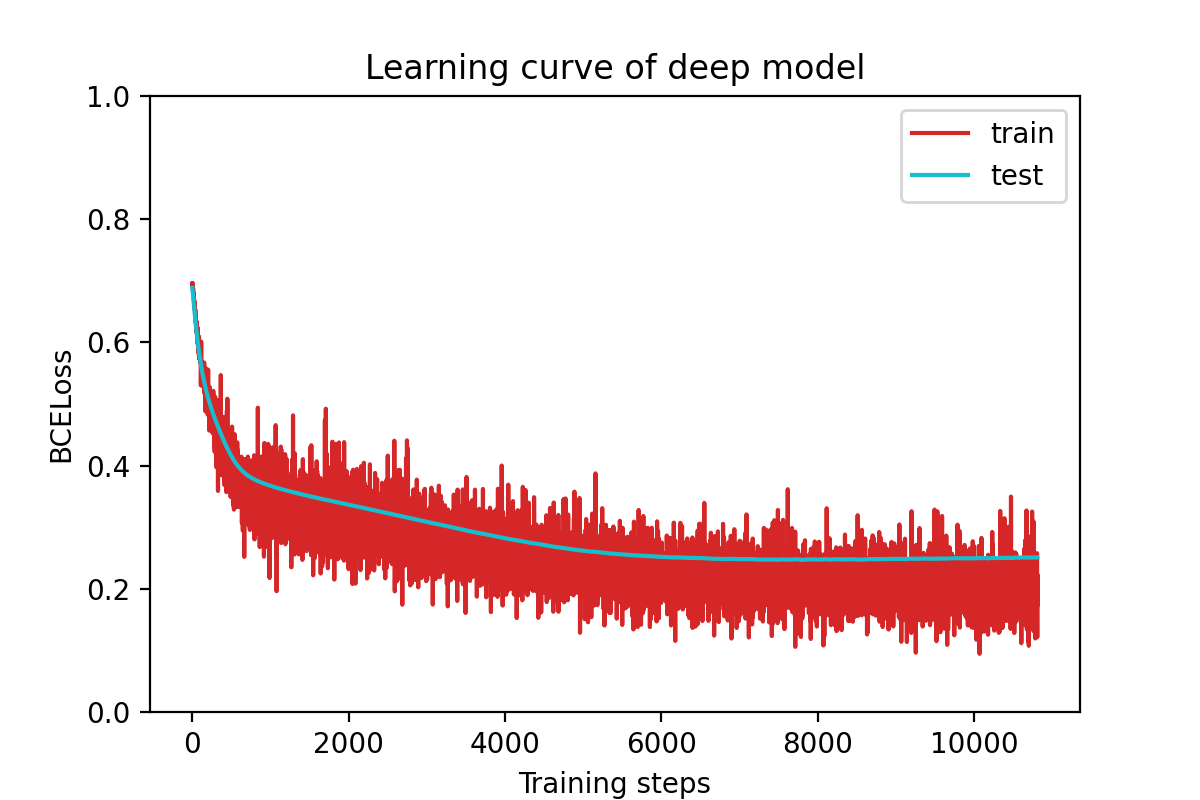

In [ ]:
plot_learning_curve(model_loss_record, title='deep model')

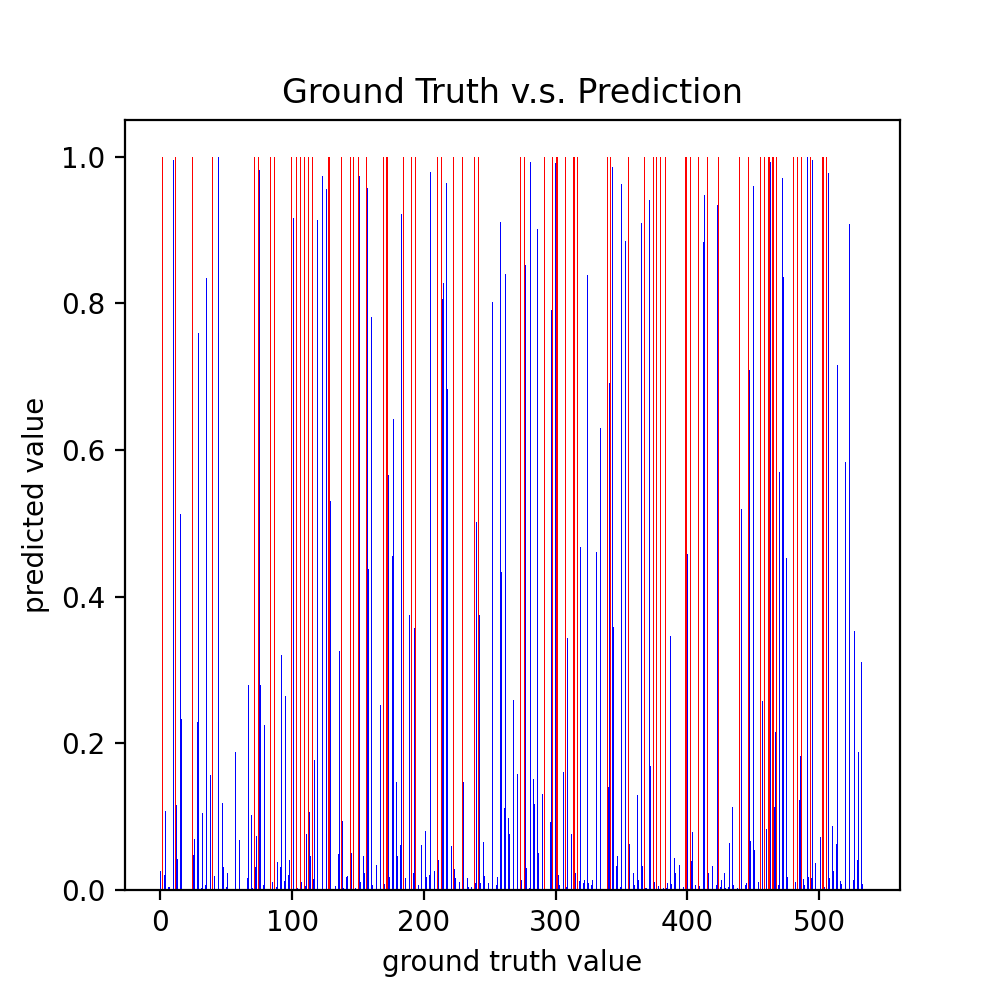

In [ ]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(tt_set, model, device, lim=1)  # Show prediction on the test set

## Model Evaluation

In [ ]:
model.eval()
preds, targets = [], []
for x, y in tt_set:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        pred = model(x)
        preds.append(pred.detach().cpu())
        targets.append(y.detach().cpu())
preds = torch.cat(preds, dim=0).numpy()
targets = torch.cat(targets, dim=0).numpy()

In [ ]:
preds1 = [1 if i >= 0.6 else 0 for i in preds]
report = classification_report(targets, preds1)
print(report)

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93       405
         1.0       0.90      0.64      0.75       130

    accuracy                           0.90       535
   macro avg       0.90      0.81      0.84       535
weighted avg       0.90      0.90      0.89       535



In [ ]:
dataset = AidsDataset(mode='train', data=data, selected=selected)
X_train, y_train = dataset.get_data()
dataset = AidsDataset(mode='test', data=data, selected=selected)
X_test, y_test = dataset.get_data()

['time', 'offtrt', 'cd420', 'race', 'cd820', 'age', 'strat_1', 'symptom', 'drugs', 'karnof', 'strat_2', 'hemo', 'cd40']
Finished reading the train set of Aids Dataset (1604 samples found, each dim = 13)
['time', 'offtrt', 'cd420', 'race', 'cd820', 'age', 'strat_1', 'symptom', 'drugs', 'karnof', 'strat_2', 'hemo', 'cd40']
Finished reading the test set of Aids Dataset (535 samples found, each dim = 13)


In [ ]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)
report1 = classification_report(y_test, y_pred)
print(report1)

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
report2 = classification_report(y_test, y_pred)
print(report2)

svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
report3 = classification_report(y_test, y_pred)
print(report3)

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report4 = classification_report(y_test, y_pred)
print(report4)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
report5 = classification_report(y_test, y_pred)
print(report5)

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.91       405
         1.0       0.78      0.52      0.63       130

    accuracy                           0.85       535
   macro avg       0.82      0.74      0.77       535
weighted avg       0.84      0.85      0.84       535

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89       405
         1.0       0.66      0.70      0.68       130

    accuracy                           0.84       535
   macro avg       0.78      0.79      0.79       535
weighted avg       0.84      0.84      0.84       535

              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93       405
         1.0       0.85      0.65      0.73       130

    accuracy                           0.89       535
   macro avg       0.87      0.80      0.83       535
weighted avg       0.88      0.89      0.88       535

              preci